<a href="https://colab.research.google.com/github/JLmm123/deep_learning/blob/main/Milestone_2_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Computer Vision

In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import json
import random

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score

if not os.path.exists('./data'):
    os.mkdir('./data')


FIND_PARAMS = False


In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False, num_workers=2)

mean_ = dataset.data.mean(axis=(0, 1, 2)) / 255
std_ = dataset.data.std(axis=(0, 1, 2)) / 255
mean_, std_

100%|██████████| 170498071/170498071 [00:12<00:00, 13679402.58it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean_, std_)])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

classes = train_dataset.classes

if os.sys.platform.startswith('darwin') and torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(f"We're going to train models on {device}.")

Files already downloaded and verified
Files already downloaded and verified
We're going to train models on cuda.


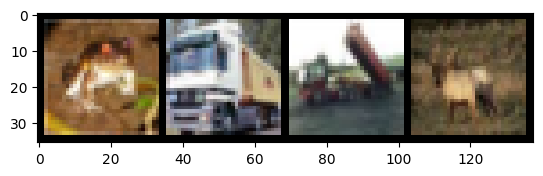

frog  truck truck deer 


In [ ]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    # npimg = npimg * std_.reshape(-1, 1, 1) + mean_.reshape(-1, 1, 1)  # unnormalize
    # npimg = np.clip(npimg, 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(dataloader)
images, labels = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[label]:5s}' for label in labels))

In [ ]:
class SoftmaxRegression(torch.nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(SoftmaxRegression, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(n_inputs, n_outputs)
        self.softmax = torch.nn.Softmax(1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        y = self.softmax(x)
        return y


In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


def train_test(model, device, criterion, optimizer, train_loader, test_loader):
    EPOCHS = 20
    y_true, y_pred = [], []

    for epoch in range(EPOCHS):
        last_epoch = epoch == EPOCHS - 1
        model.train()

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            predictions = model(inputs)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

        model.eval()

        with torch.no_grad():
            for i, data in enumerate(test_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                predictions = model(inputs)

                _, predicted = torch.max(predictions, 1)
                if last_epoch:
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(predicted.cpu().numpy())

    score = f1_score(y_true, y_pred, average='macro')
    # print(y_true, y_pred)

    return score

criterion = nn.CrossEntropyLoss()


In [ ]:
if FIND_PARAMS:
    trainset_size = len(train_dataset)
    train_indices = list(range(trainset_size))
    train_split = int(np.floor(0.2 * trainset_size))

    np.random.seed(42)
    np.random.shuffle(train_indices)

    train_indices = train_indices[: train_split]
    train_sampler = SubsetRandomSampler(train_indices)

    set_seed(42)
    param_grid = {
        'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10)),
        'batch_size': [1, 128, 256, 512],
        'optimizer': [optim.SGD, optim.Adagrad, optim.Adam, optim.Adadelta]
    }

    MAX_EVALS = 100

    best_score = 0
    best_hyperparams = {}
    for i in tqdm(range(MAX_EVALS), ascii="123456789$", desc="Searching Hyperparams"):
        random.seed(i)
        model = SoftmaxRegression(3 * 32 * 32, 10).to(device)

        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}

        learning_rate = hyperparameters['learning_rate']
        batch_size = hyperparameters['batch_size']
        optimizer = hyperparameters['optimizer'](model.parameters(), lr=learning_rate)

        train_loader = torch.utils.data.DataLoader(
                train_dataset, batch_size=batch_size, num_workers=2, sampler=train_sampler)
        test_loader = torch.utils.data.DataLoader(
                test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

        score = train_test(
                    model, device, criterion, optimizer, train_loader, test_loader)

        if score > best_score:
            best_hyperparams = hyperparameters
            best_score = score
            print(f'New best score: {best_score}\nparams: {hyperparameters}')
        # break
else:
        best_hyperparams = {
            "learning_rate": 0.007999293598030286,
            "batch_size": 128,
            "optimizer": optim.Adagrad}

In [ ]:
print(best_hyperparams)

model = SoftmaxRegression(3 * 32 * 32, 10).to(device)

learning_rate = best_hyperparams['learning_rate']
batch_size = best_hyperparams['batch_size']
optimizer = best_hyperparams['optimizer'](model.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size,shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


train_loss, test_loss = [], []
train_acc, test_acc = [], []

EPOCHS = 20
for epoch in range(EPOCHS):

    model.train()
    running_loss = 0.
    correct, total = 0, 0

    for i, data in enumerate(train_loader, 0):

        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        predictions = model(inputs)

        optimizer.zero_grad()

        loss = criterion(predictions, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(running_loss / len(train_loader))
    train_acc.append(correct / total)

    model.eval()
    running_loss = 0.
    correct, total = 0, 0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)

            running_loss += loss.item()

            _, predicted = torch.max(predictions, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss.append(running_loss / len(test_loader))
    test_acc.append(correct / total)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}:")

        print(f"Training Loss:", round(train_loss[epoch], 3))
        print(f"Test Loss:", round(test_loss[epoch], 3))

        print(f"Training Accuracy:", round(train_acc[epoch], 3))
        print(f"Test Accuracy:", round(test_acc[epoch], 3))

        print("------------------------------")

{'learning_rate': 0.007999293598030286, 'batch_size': 128, 'optimizer': <class 'torch.optim.adagrad.Adagrad'>}
Epoch 5:
Training Loss: 2.031
Test Loss: 2.052
Training Accuracy: 0.432
Test Accuracy: 0.407
------------------------------
Epoch 10:
Training Loss: 2.017
Test Loss: 2.048
Training Accuracy: 0.449
Test Accuracy: 0.412
------------------------------
Epoch 15:
Training Loss: 2.01
Test Loss: 2.047
Training Accuracy: 0.458
Test Accuracy: 0.412
------------------------------
Epoch 20:
Training Loss: 2.005
Test Loss: 2.047
Training Accuracy: 0.464
Test Accuracy: 0.411
------------------------------


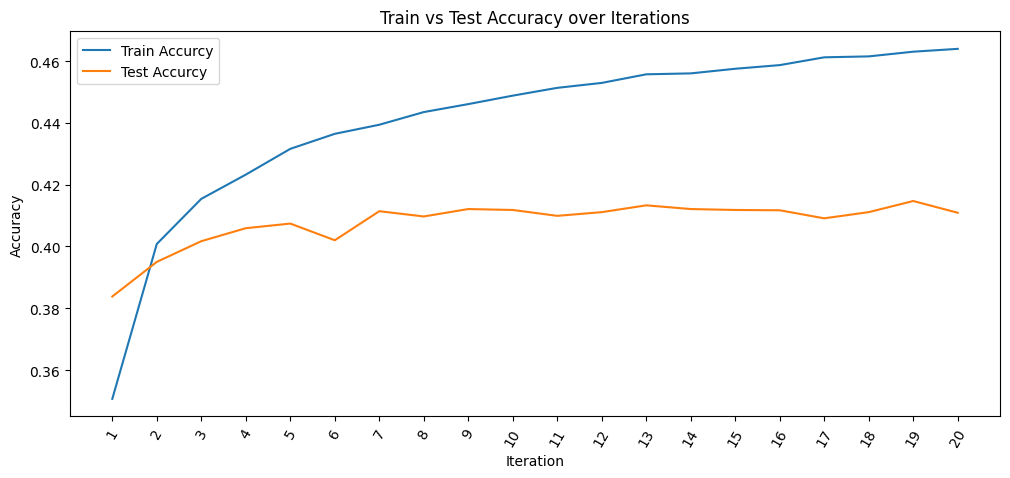

In [ ]:
x = np.arange(1, EPOCHS + 1)

plt.figure(1, (12, 5))

plt.plot(x, train_acc)
plt.plot(x, test_acc)
plt.xticks(x, rotation=60)

plt.xlabel('Iteration')
plt.ylabel('Accuracy')

plt.legend(['Train Accurcy', 'Test Accurcy'])

plt.title('Train vs Test Accuracy over Iterations')
plt.show();

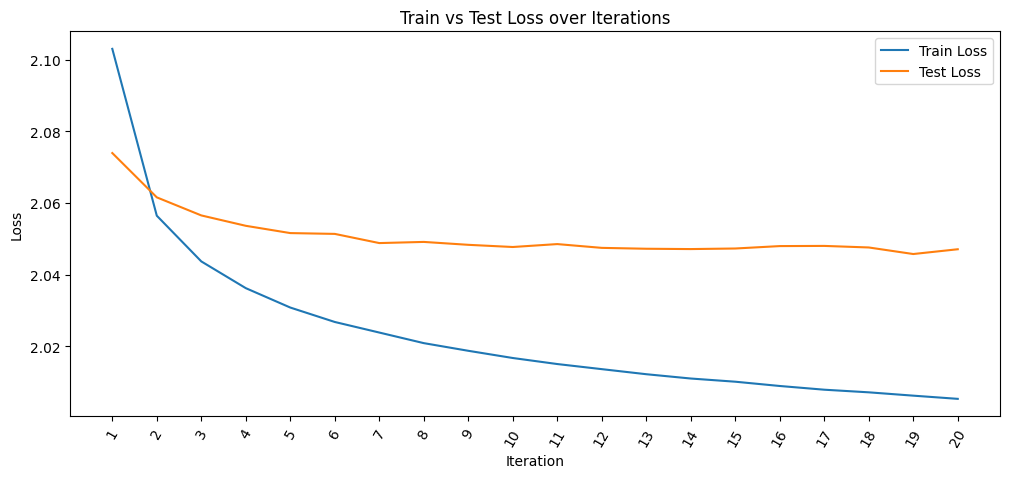

In [ ]:
plt.figure(1, (12, 5))

plt.plot(x, train_loss)
plt.plot(x, test_loss)
plt.xticks(x, rotation=60)

plt.xlabel('Iteration')
plt.ylabel('Loss')


plt.legend(['Train Loss', 'Test Loss'])

plt.title('Train vs Test Loss over Iterations')
plt.show();

In [ ]:
model.eval()
test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True, persistent_workers=True, prefetch_factor=4194304//batch_size)
running_loss = 0.
correct, total = 0, 0
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data

        inputs = inputs.to(device)

        labels = labels.to(device)

        predictions = model(inputs)

        loss = criterion(predictions, labels)

        running_loss += loss.item()

        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test loss (without shifting): {running_loss / len(test_loader)}')
print(f'Test accu (without shifting): {correct / total}')


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test loss (without shifting): 2.047091820571996
Test accu (without shifting): 0.4109


In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa

class AugmentedCIFAR10(torchvision.datasets.CIFAR10):
    def __init__(self, root, train=False, transform=None, target_transform=None, download=False, augment_percent=0.1):
        super().__init__(root, train=train, transform=transform, target_transform=target_transform, download=download)
        self.augment_percent = augment_percent
        self.augment_indices = np.random.choice(len(self.data), int(len(self.data) * self.augment_percent), replace=False)
        self.augmenter = iaa.Sequential([
            iaa.SomeOf((2, 3), [
                iaa.Crop(percent=(0, 0.1)),
                iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}),
                iaa.Multiply((0.8, 1.2)),
                iaa.Rotate((-10, 10)),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5)
            ])
        ])

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]

        # Convert img from numpy array to PIL image for compatibility with torchvision transforms
        img = transforms.ToPILImage()(img)

        if index in self.augment_indices:
            img = np.array(img)  # Convert PIL image to numpy array for imgaug
            img = self.augmenter.augment_image(img)
            img = transforms.ToPILImage()(img)  # Convert back to PIL image after augmentation

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

# Usage
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean_, std_)])
augmented_test_set = AugmentedCIFAR10(root='./data', train=False, download=True, transform=transform, augment_percent=1)
test_loader = torch.utils.data.DataLoader(augmented_test_set, batch_size=64, shuffle=False)


Files already downloaded and verified


In [ ]:
model.eval()
running_loss = 0.
correct, total = 0, 0
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data

        inputs = inputs.to(device)

        labels = labels.to(device)

        predictions = model(inputs)

        loss = criterion(predictions, labels)

        running_loss += loss.item()

        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test loss (with shifting): {running_loss / len(test_loader)}')
print(f'Test accu (with shifting): {correct / total}')

Test loss (with shifting): 2.145965327123168
Test accu (with shifting): 0.3071
